In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c358b4247b5c65e1e79b558d0b5b06f3aa015348226014d6d592a166cb0578fb
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [31]:
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import LinearRegression

from pyspark.sql.functions import col, sum as sql_sum

from pyspark.sql.types import IntegerType

from pyspark.ml.feature import StringIndexer

from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.mllib.util import MLUtils

import matplotlib.pyplot as plt

from pyspark.ml.stat import Correlation

import sys as sns

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml import Pipeline

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import RandomForestClassifier

from pyspark.sql import SparkSession

import matplotlib.pyplot as plt

import seaborn as sns

from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pyspark.sql.functions as F


# **Spark Session initialization**

In [53]:
spark = SparkSession.builder \
   .appName("random forest classifier") \
   .getOrCreate()

train_data = spark.read.format("csv") \
                .option("header", "true") \
                .option("inferSchema", "true") \
                .load("file:////content/UCI_Credit_Card.csv")

train_data = train_data.withColumnRenamed("default.payment.next.month", "default_payment_next_month")
train_data.show()


+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default_payment_next_month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|  20000.0|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|   3913.0|   3102.0|    689.0|      0.0|      0.0|      0.0|     0.0|   689.0|     0.0|     0.0|     0.0|     0.0|                         1|
|  2| 120000.0|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|   2682.0|   1725.0|   2682.0|   3272.0|  

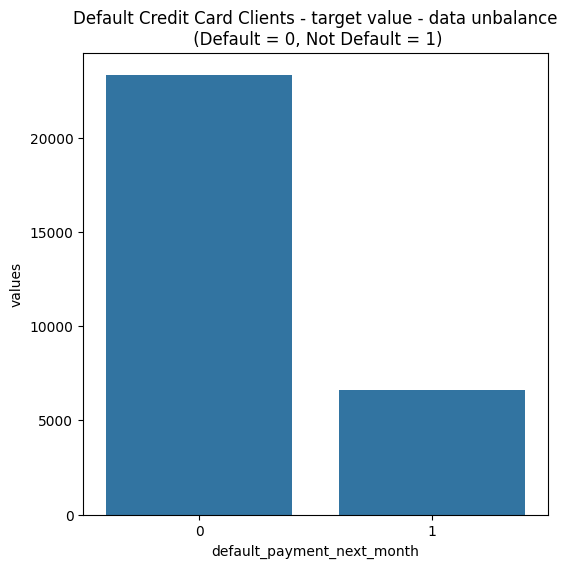

In [54]:
temp = train_data.groupBy("default_payment_next_month").count().toPandas()
temp.columns = ['default_payment_next_month', 'values']

# Plotting
plt.figure(figsize=(6, 6))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x='default_payment_next_month', y='values', data=temp)
plt.show()

<ipython-input-56-77da3add7909>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(limit_bal_pd['LIMIT_BAL'], kde=True, bins=200, color="blue")


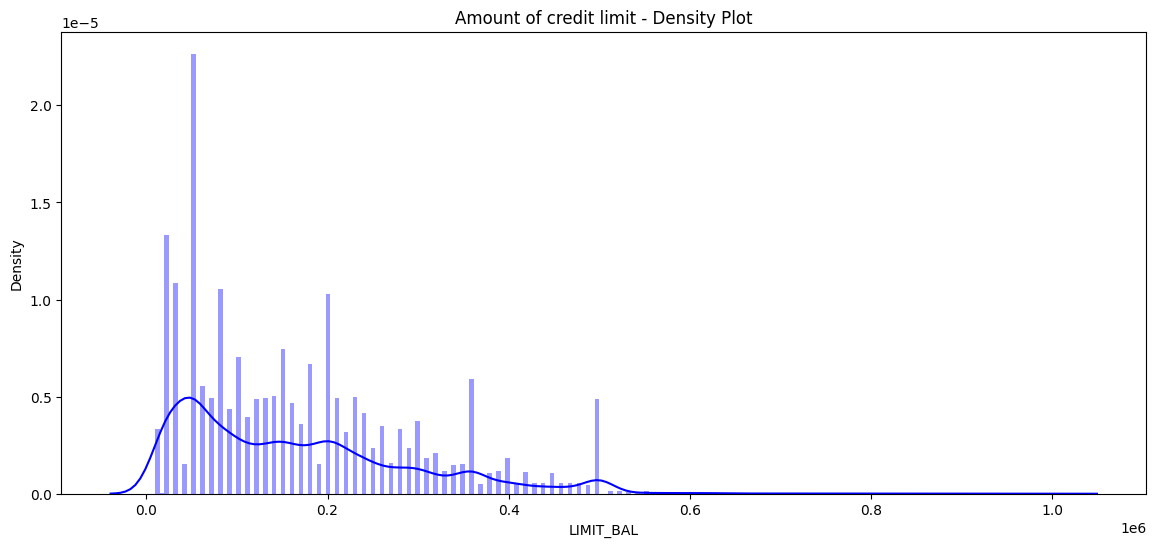

In [56]:
limit_bal_pd = train_data.select('LIMIT_BAL').toPandas()

# Plotting
plt.figure(figsize=(14, 6))
plt.title('Amount of credit limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(limit_bal_pd['LIMIT_BAL'], kde=True, bins=200, color="blue")
plt.show()

In [59]:
#### distinct values for amount of credit limit ####

top_5_values = train_data.groupBy('LIMIT_BAL').count().orderBy('count', ascending=False).head(5)
top_5_values_df = spark.createDataFrame(top_5_values)
top_5_values_df.show()

+---------+-----+
|LIMIT_BAL|count|
+---------+-----+
|  50000.0| 3365|
|  20000.0| 1976|
|  30000.0| 1610|
|  80000.0| 1567|
| 200000.0| 1528|
+---------+-----+



**balance limit in credit card : the maximum amount of money you can owe at any one time on that card.**

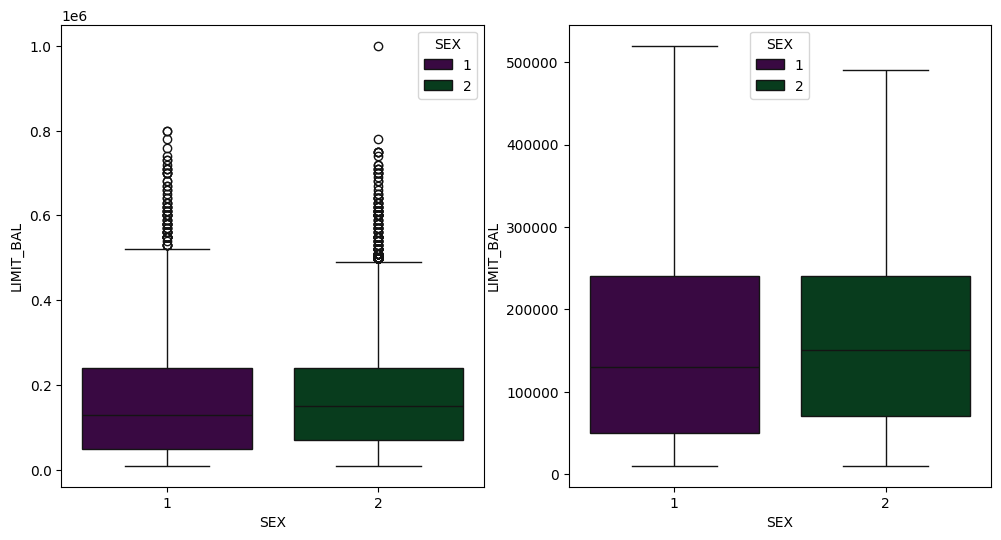

In [60]:
data_pd = train_data.toPandas()

# Plotting
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
sns.boxplot(ax=ax1, x="SEX", y="LIMIT_BAL", hue="SEX", data=data_pd, palette="PRGn", showfliers=True)
sns.boxplot(ax=ax2, x="SEX", y="LIMIT_BAL", hue="SEX", data=data_pd, palette="PRGn", showfliers=False)
plt.show()

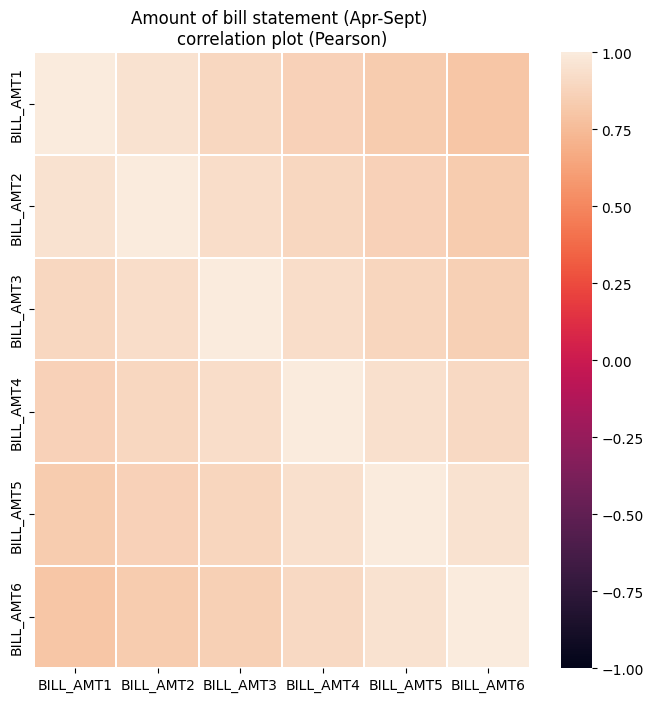

In [61]:
train_data_pandas = train_data.toPandas()

# Select the variables of interest
var = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Plotting
plt.figure(figsize=(8, 8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data_pd[var].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, vmin=-1, vmax=1)
plt.show()


### correlation of Amount of bill statement in April - September 2005 ###

### Correlation is decreasing with distance between months. Lowest correlations are between Sept-April. ###

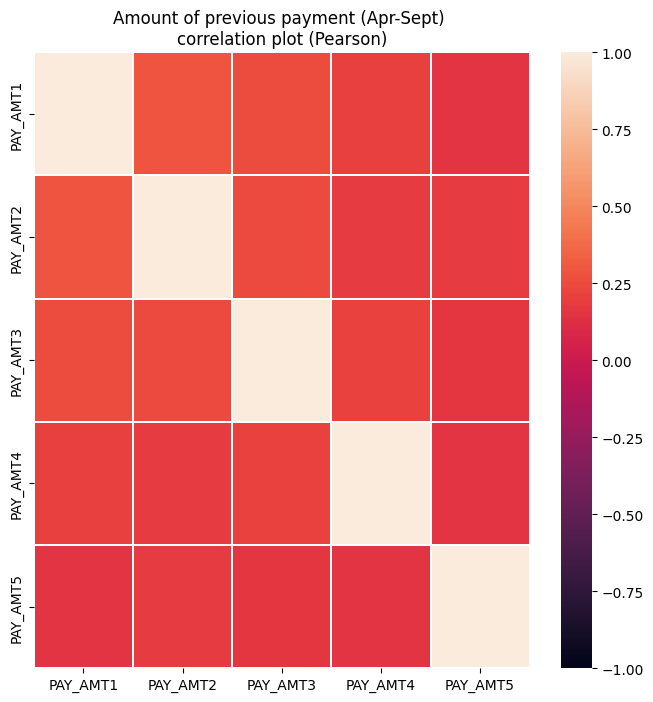

In [62]:
var = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']

plt.figure(figsize = (8,8))
plt.title('Amount of previous payment (Apr-Sept) \ncorrelation plot (Pearson)')
corr = train_data_pandas[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

###  correlation of Amount of previous payment in April - September 2005. ###

### There are no correlations between amounts of previous payments for April-Sept 2005. ###

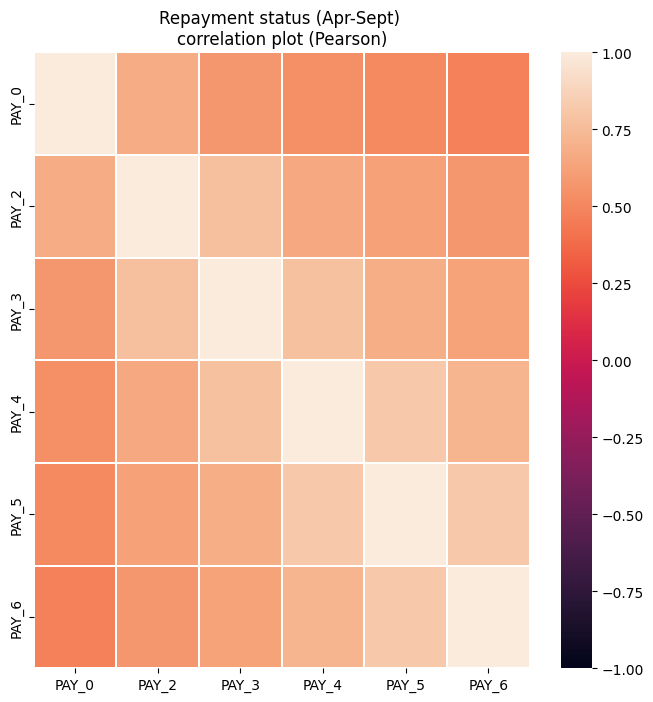

In [63]:
var = ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

plt.figure(figsize = (8,8))
plt.title('Repayment status (Apr-Sept) \ncorrelation plot (Pearson)')
corr = train_data_pandas[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()
### correlation between Repayment status in April - September 2005.###
### Correlation is decreasing with distance between months. Lowest correlations are between Sept-April. ###

# **StringIndexer : Using strin indexer to convert string values to double intigers.**

In [75]:
indexer = StringIndexer(inputCols=[  'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
                        outputCols=[  'LIMIT_BAL_inx', 'SEX_inx', 'EDUCATION_inx', 'MARRIAGE_inx', 'AGE_inx',
                'PAY_0_inx', 'PAY_2_inx', 'PAY_3_inx', 'PAY_4_inx', 'PAY_5_inx', 'PAY_6_inx',
                'BILL_AMT1_inx','BILL_AMT2_inx', 'BILL_AMT3_inx', 'BILL_AMT4_inx', 'BILL_AMT5_inx', 'BILL_AMT6_inx',
                'PAY_AMT1_inx', 'PAY_AMT2_inx', 'PAY_AMT3_inx', 'PAY_AMT4_inx', 'PAY_AMT5_inx', 'PAY_AMT6_inx']).fit(train_data)
indexed_df = indexer.transform(train_data)
assembler = VectorAssembler(inputCols=[
 'LIMIT_BAL_inx',
 'SEX_inx',
 'EDUCATION_inx',
 'MARRIAGE_inx',
 'AGE_inx',
 'PAY_0_inx',
 'PAY_2_inx',
 'PAY_3_inx',
 'PAY_4_inx',
 'PAY_5_inx',
 'PAY_6_inx',
 'BILL_AMT1_inx',
 'BILL_AMT2_inx',
 'BILL_AMT3_inx',
 'BILL_AMT4_inx',
 'BILL_AMT5_inx',
 'BILL_AMT6_inx',
 'PAY_AMT1_inx',
 'PAY_AMT2_inx',
 'PAY_AMT3_inx',
 'PAY_AMT4_inx',
 'PAY_AMT5_inx',
 'PAY_AMT6_inx'
 ], outputCol='Independant_Features')

output  = assembler.transform(indexed_df)

final_df = output.select("Independant_Features","default_payment_next_month")

### final_df is the dataframe that has feature coloumn as corresponding vector(Independant_Features) , and the lable that we have to predict default_payment_next_month ###

training, test = final_df.randomSplit([0.7, 0.3])

# training.show()
rf = RandomForestClassifier(labelCol="default_payment_next_month", featuresCol="Independant_Features", numTrees=36)

training, test = train_data.randomSplit([0.7, 0.3])

# Define the features and target column
target = 'default_payment_next_month'
predictors = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
              'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
              'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Create a vector assembler
assembler = VectorAssembler(inputCols=predictors, outputCol="features")

# Transform the data
train_df = assembler.transform(training)
val_df = assembler.transform(test)

# Create a RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol=target,
                            numTrees=100, seed=42)

train_df = train_df.withColumnRenamed("default.payment.next.month", "default_payment_next_month")
val_df = val_df.withColumnRenamed("default.payment.next.month", "default_payment_next_month")

# # Train the model
model = rf.fit(train_df)

# Make predictions on the validation set
preds = model.transform(val_df)

# # Extract feature importances
# importances = model.featureImportances.toArray()

preds.select('PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default_payment_next_month','features','rawPrediction','probability','prediction')

preds.show()


+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+--------------------+--------------------+--------------------+----------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default_payment_next_month|            features|       rawPrediction|         probability|prediction|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+--------------------+--------------------+--------------------+----------+
|  9| 140000.0|  2|        3|       1| 28|    0|    0|    2|    0|    0|    0|  11285.0|  14096.0|  12108.0|  12211.0|

In [41]:

# Create a binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol=target)

# Calculate the ROC AUC score
roc_auc = evaluator.evaluate(preds)

print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.7730336305295239


ROC AUC Score: 0.7730336305295239


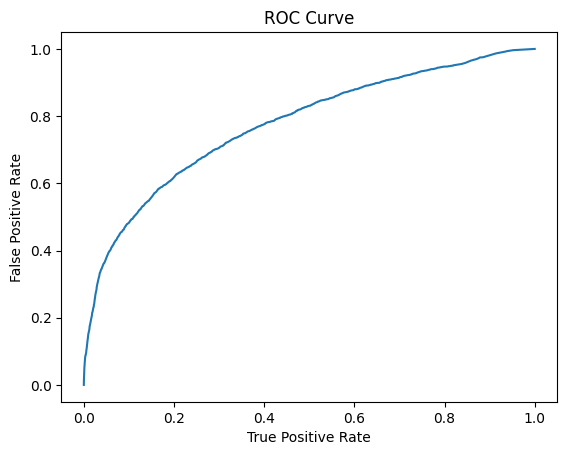

Training set areaUnderROC: 0.775134808446721


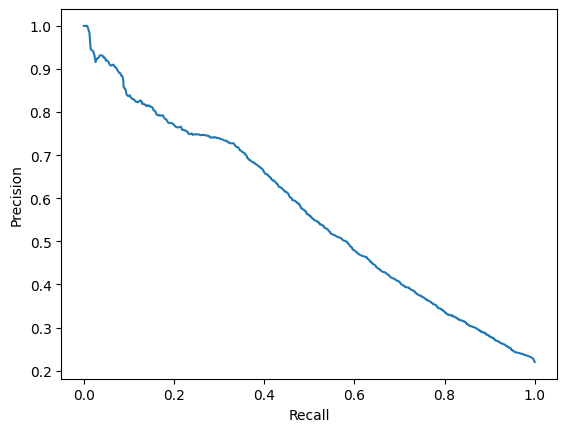

In [42]:

# Create a binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol=target)

# Calculate the ROC AUC score
roc_auc = evaluator.evaluate(preds)

print(f"ROC AUC Score: {roc_auc}")

trainingSummary = model.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))




pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()



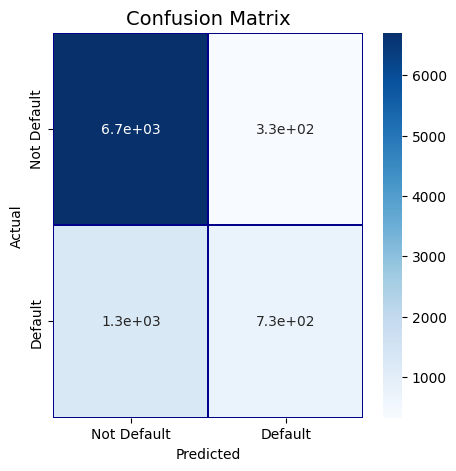

In [43]:
preds_pd = preds.select(['prediction', target]).toPandas()

# Rename the prediction column for clarity
preds_pd = preds_pd.rename(columns={'prediction': 'Predicted'})

# Create the confusion matrix
cm = pd.crosstab(preds_pd[target], preds_pd['Predicted'], rownames=['Actual'], colnames=['Predicted'])

# Plot the confusion matrix
fig, ax1 = plt.subplots(ncols=1, figsize=(5, 5))
sns.heatmap(cm,
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True, ax=ax1,
            linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [44]:
f_tp = preds.filter((col("default_payment_next_month") == 1)).count()
f_tn = preds.filter((col("default_payment_next_month") == 0)).count()


In [45]:
### TRUE POSITIVE ###
### positive and classified as positive. This is called TRUE POSITIVE (TP). ###

tp = preds.filter((col("default_payment_next_month") == 1) & (col('prediction') == 1)).count()


### TRUE NEGATIVE ###
### negative and classified as negative. This is called TRUE NEGATIVE (TN). ###
tn = preds.filter((col("default_payment_next_month") == 0) & (col('prediction') == 0)).count()

### FALSE POSITIVE ###
### negative and classified as positive. This is called FALSE POSITIVE (FP). ###
fp = preds.filter((col("default_payment_next_month") == 0) & (col('prediction') == 1)).count()

### FALSE NEGATIVE ###
### positive and classified as negative. This is called FALSE NEGATIVE (FN). ###
fn = preds.filter((col("default_payment_next_month") == 1) & (col('prediction') == 0)).count()

# Calculate accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
print(f"Precision: {precision}")

# Calculate recall
recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
print(f"Recall: {recall}")

# Calculate F1 measure
f1_measure = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
print(f"F1 measure: {f1_measure}")

Accuracy: 0.8207422133863486
Precision: 0.6897533206831119
Recall: 0.35936727632229365
F1 measure: 0.47253818654533636


In [46]:
tp_a = (tp / f_tp) * 100
print(f"true accuracy : {tp_a}")

true accuracy : 35.93672763222936
